# Study note about behaviors of learning ARD weights

In [9]:
import numpy
import sys
sys.path.append("../")
sys.path.append(".")
from model_criticism_mmd import ModelTrainerTorchBackend, MMD, ModelTrainerTheanoBackend
from model_criticism_mmd.backends import kernels_torch

In [10]:
import torch
device_obj = torch.device('cpu')

# Study: Correctness of ARD weightts

## objective

1. We confirm the computed ARD weights are as we expected.
2. We observe how the sigma value works on learninig the ARD weights.

## Settings

We generate the input data with the following way.

The input data has 3 dimensions. Only the 1st dimenstion has huge variance. The 2nd and 3rd features have the same mean and variance.

We cut the input data into 80 samples as `training` and 20 samples as `validation`.

In [13]:
size = 100
n_trial = 5
n_epoch = 500
batch_size = 200

result_stacks_with_sigma = []
result_stacks_without_sigma = []
for i_trial in range(0, n_trial):
    x_1st_dim = numpy.random.normal(loc=1.0, scale=0.0, size=size)
    y_1st_dim = numpy.random.normal(loc=1.0, scale=50.0, size=size)

    x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
    y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

    x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
    y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)
    
    x_train = x[:80]
    y_train = y[:80]
    x_val = x[80:]
    y_val = y[80:]

    for n_dim in [0, 1, 2]:
        print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
    # end for
    
    # with sigma optimization
    trainer_theano = ModelTrainerTheanoBackend()
    trained_obj_theano = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=True, x_val=x_val, y_val=y_val, init_sigma_median=True)
    
    mmd_estimator_sigma_opt = MMD(kernels_torch.BasicRBFKernelFunction(opt_sigma=True, device_obj=device_obj), 
                                  device_obj=device_obj)
    trainer_torch = ModelTrainerTorchBackend(mmd_estimator=mmd_estimator_sigma_opt,
                                            device_obj=device_obj)
    trained_obj_torch = trainer_torch.train(x, y, num_epochs=n_epoch, batchsize=batch_size, x_val=x_val, y_val=y_val)
    sigma = numpy.exp(trained_obj_torch.kernel_function_obj.get_params()['log_sigma'].cpu().detach().numpy())

    result_stacks_with_sigma.append([
                             (x, y),
                             (trained_obj_theano.scales, trained_obj_torch.scales),
                             (trained_obj_theano.sigma, sigma)])
    # without sigma optimization
    trainer_theano = ModelTrainerTheanoBackend()
    trained_obj_theano = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=False, x_val=x_val, y_val=y_val, init_sigma_median=False, init_log_sigma=0.0)
    
    mmd_estimator = MMD(kernels_torch.BasicRBFKernelFunction(opt_sigma=False, device_obj=device_obj), 
                        device_obj=device_obj)
    trainer_torch = ModelTrainerTorchBackend(mmd_estimator=mmd_estimator,
                                            device_obj=device_obj)
    trained_obj_torch = trainer_torch.train(x, y, num_epochs=n_epoch, batchsize=batch_size, x_val=x_val, y_val=y_val)
    sigma = numpy.exp(trained_obj_torch.kernel_function_obj.get_params()['log_sigma'].cpu().detach().numpy())
    
    result_stacks_without_sigma.append([
                             (x, y),
                             (trained_obj_theano.scales, trained_obj_torch.scales),
                             (trained_obj_theano.sigma, sigma)])
# end for

Starting with sigma = median; optimizing it


1 dim. mean(x)=1.0 mean(y)=-0.24691752354141447 var(x)=0.0 var(y)=2221.8616800853933
2 dim. mean(x)=9.976288518938036 mean(y)=9.986967058875578 var(x)=0.053024880047805235 var(y)=0.03486053879001614
3 dim. mean(x)=9.954404343887898 mean(y)=10.018657445174059 var(x)=0.05211927983926969 var(y)=0.04965255054954731


Compiling...
done
Getting median initial sigma value...
20
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.533503 obj -2.067013,  avg val MMD^2  0.554687  obj -1.467783  elapsed: 0s  sigma: 20
     5: avg train MMD^2  0.572771 obj -2.109349,  avg val MMD^2  0.607115  obj -1.511636  elapsed: 0s  sigma: 18.6
    25: avg train MMD^2  0.840772 obj -2.681594,  avg val MMD^2  0.824687  obj -1.930154  elapsed: 0s  sigma: 8.91
    50: avg train MMD^2  0.968537 obj -3.580443,  avg val MMD^2  0.973255  obj -2.841171  elapsed: 0s  sigma: 2.4
   100: avg train MMD^2  0.951768 obj -3.711163,  avg val MMD^2  1.002283  obj -4.440144  elapsed: 0s  sigma: 1.3
   200: avg train MMD^2  1.009562 obj -6.445388,  avg val MMD^2  1.048937  obj -8.441660  elapsed: 0s  sigma: 0.18
   300: avg train MMD^2  0.025000 obj -5.521461,  avg val MMD^2  0.100000  obj -6.907755  elapsed: 0s  sigma: 0

1 dim. mean(x)=1.0 mean(y)=-1.4897334158146975 var(x)=0.0 var(y)=2512.6160148898744
2 dim. mean(x)=9.957249894956414 mean(y)=10.00657962225773 var(x)=0.03483701065945324 var(y)=0.042540783857637134
3 dim. mean(x)=10.019732587994879 mean(y)=10.022977534302427 var(x)=0.043891168059577226 var(y)=0.044985531937830156


Compiling...
done
Getting median initial sigma value...
18.5
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.518410 obj -2.139044,  avg val MMD^2  0.457794  obj -1.437176  elapsed: 0s  sigma: 18.5
     5: avg train MMD^2  0.580523 obj -2.249668,  avg val MMD^2  0.548464  obj -1.596994  elapsed: 0s  sigma: 16.5
    25: avg train MMD^2  0.887340 obj -2.747882,  avg val MMD^2  0.973318  obj -2.284882  elapsed: 0s  sigma: 7.81
    50: avg train MMD^2  0.929388 obj -3.106468,  avg val MMD^2  0.993065  obj -2.621255  elapsed: 0s  sigma: 3.44
   100: avg train MMD^2  0.943217 obj -3.649173,  avg val MMD^2  1.015187  obj -4.760940  elapsed: 0s  sigma: 1.1
   200: avg train MMD^2  0.972742 obj -3.682711,  avg val MMD^2  1.040510  obj -5.384379  elapsed: 0s  sigma: 1.03
   300: avg train MMD^2  0.982451 obj -3.692299,  avg val MMD^2  1.048080  obj -5.674502  elapsed: 0s  sig

1 dim. mean(x)=1.0 mean(y)=4.053417627866132 var(x)=0.0 var(y)=3038.0366123964304
2 dim. mean(x)=10.002684324814638 mean(y)=9.994789211613279 var(x)=0.03766186689307165 var(y)=0.04448385978815304
3 dim. mean(x)=10.034713842325218 mean(y)=9.980586130871755 var(x)=0.028926944494639666 var(y)=0.04645665187347826


Compiling...
done
Getting median initial sigma value...
26.2
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.530171 obj -2.110833,  avg val MMD^2  0.748759  obj -2.034917  elapsed: 0s  sigma: 26.2
     5: avg train MMD^2  0.573502 obj -2.146124,  avg val MMD^2  0.834693  obj -2.082668  elapsed: 0s  sigma: 24.5
    25: avg train MMD^2  0.821764 obj -2.527718,  avg val MMD^2  1.065168  obj -2.299718  elapsed: 0s  sigma: 13.4
    50: avg train MMD^2  0.948843 obj -3.115994,  avg val MMD^2  1.036100  obj -2.797502  elapsed: 0s  sigma: 4.71
   100: avg train MMD^2  0.944481 obj -3.210767,  avg val MMD^2  1.058907  obj -4.529129  elapsed: 0s  sigma: 2.36
   200: avg train MMD^2  0.938275 obj -4.086464,  avg val MMD^2  1.025612  obj -4.639207  elapsed: 0s  sigma: 0.773
   300: avg train MMD^2  0.663102 obj -2.991827,  avg val MMD^2  0.787840  obj -2.807248  elapsed: 0s  s

1 dim. mean(x)=1.0 mean(y)=-2.585342907444032 var(x)=0.0 var(y)=3676.4312399801333
2 dim. mean(x)=10.000367243976408 mean(y)=9.992368150274995 var(x)=0.03389158196912129 var(y)=0.04708181416702484
3 dim. mean(x)=10.039289127535456 mean(y)=10.001012445305845 var(x)=0.035214451805337436 var(y)=0.04073979796852863


Compiling...
done
Getting median initial sigma value...
28.4
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.541283 obj -2.204188,  avg val MMD^2  0.564744  obj -1.597090  elapsed: 0s  sigma: 28.4
     5: avg train MMD^2  0.600841 obj -2.260699,  avg val MMD^2  0.649081  obj -1.641353  elapsed: 0s  sigma: 26.2
    25: avg train MMD^2  0.865483 obj -2.583277,  avg val MMD^2  0.887103  obj -2.062777  elapsed: 0s  sigma: 14.7
    50: avg train MMD^2  0.973978 obj -3.471818,  avg val MMD^2  1.051395  obj -4.603929  elapsed: 0s  sigma: 4.39
   100: avg train MMD^2  1.014162 obj -7.197709,  avg val MMD^2  1.049262  obj -8.722885  elapsed: 0s  sigma: 0.665
   200: avg train MMD^2  1.012841 obj -8.291357,  avg val MMD^2  1.050000  obj -9.259131  elapsed: 0s  sigma: 0.0498
   300: avg train MMD^2  0.025000 obj -5.521461,  avg val MMD^2  0.100000  obj -6.907755  elapsed: 0s 

AssertionError: 

### Observations

(0.0, 15.0)

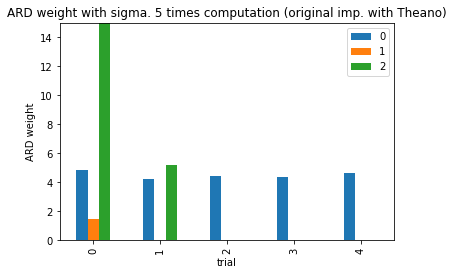

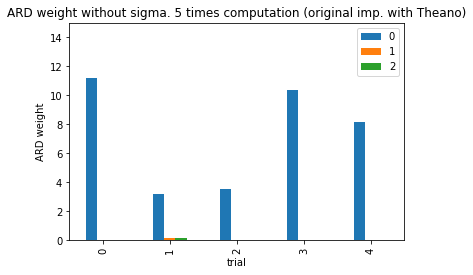

In [48]:
# Theano imp.
__df_with_sigma = []
__df_without_sigma = []
for trial_with_sigma, trial_without_sigma in zip(result_stacks_with_sigma, result_stacks_without_sigma):
    __df_with_sigma.append(trial_with_sigma[1][0])
    __df_without_sigma.append(trial_without_sigma[1][0])
# end for
df_with_sigma = pandas.DataFrame(__df_with_sigma, index = list(range(0, n_trial)))
ax = df_with_sigma.plot(kind='bar')
plt.title(f"ARD weight with sigma. {n_trial} times computation (original imp. with Theano)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(, 15)
# plot without sigma
df_without_sigma = pandas.DataFrame(__df_without_sigma, index = list(range(0, n_trial)))
ax = df_without_sigma.plot(kind='bar')
plt.title(f"ARD weight without sigma. {n_trial} times computation (original imp. with Theano)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(, 15)

(0.0, 15.0)

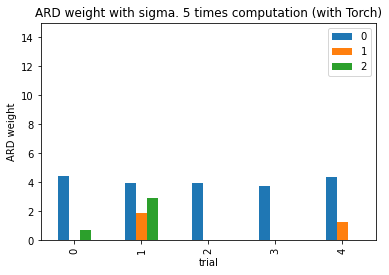

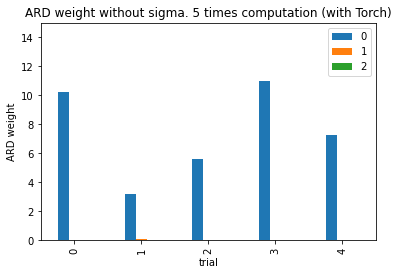

In [49]:
# Theano imp.
__df_with_sigma = []
__df_without_sigma = []
for trial_with_sigma, trial_without_sigma in zip(result_stacks_with_sigma, result_stacks_without_sigma):
    __df_with_sigma.append(trial_with_sigma[1][1])
    __df_without_sigma.append(trial_without_sigma[1][1])
# end for
df_with_sigma = pandas.DataFrame(__df_with_sigma, index = list(range(0, n_trial)))
ax = df_with_sigma.plot(kind='bar')
plt.title(f"ARD weight with sigma. {n_trial} times computation (with Torch)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 15)
# plot without sigma
df_without_sigma = pandas.DataFrame(__df_without_sigma, index = list(range(0, n_trial)))
ax = df_without_sigma.plot(kind='bar')
plt.title(f"ARD weight without sigma. {n_trial} times computation (with Torch)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 15)

### conclusion

The computed ARD weight will not be as we expected __if__ we optimize sigma value at the same time.

Then, we should tune __only scales (ARD weight)__ if we want to obtain the ARD weight.

In [ ]:
%reset

# Study: stability of ARD weights

## Objective

To confirm the computed ARD weighted will be similar.

In the exp, we have the following conditions,

- the training data x and y are fixed.
- the validation data x and y are fixed.
- sigma will not be tuned

In [19]:
from model_criticism_mmd import ModelTrainerTheanoBackend, ModelTrainerTorchBackend

In [20]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import numpy

In [24]:
size = 100
x_1st_dim = numpy.random.normal(loc=1.0, scale=0.0, size=size)
y_1st_dim = numpy.random.normal(loc=1.0, scale=50.0, size=size)

x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)

x_train = x[:80]
y_train = y[:80]
x_val = x[80:]
y_val = y[80:]

for n_dim in [0, 1, 2]:
    print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
# end for

1 dim. mean(x)=1.0 mean(y)=5.88268324033833 var(x)=0.0 var(y)=2581.977256325252
2 dim. mean(x)=9.973029705725683 mean(y)=10.00802135093335 var(x)=0.028781844253832095 var(y)=0.029758249712898838
3 dim. mean(x)=9.99467942716704 mean(y)=9.988748332579542 var(x)=0.04884625612449244 var(y)=0.03747702442607639


In [33]:
result_stacks = []
n_trial = 5
n_epoch = 500
batch_size = 200
is_opt_sigma = False
for i_trial in range(0, n_trial):
    trainer_theano = ModelTrainerTheanoBackend()
    trained_obj_theano = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=False, init_log_sigma=0.0)

    trainer_torch = ModelTrainerTorchBackend()
    trained_obj_torch = trainer_torch.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=False, initial_log_sigma=0.0)

    result_stacks.append([
                             (trained_obj_theano.scales, trained_obj_torch.scales),
                             (trained_obj_theano.sigma, trained_obj_torch.sigma)
    ])
# end for

Using sigma = 1.0
Compiling...
done
Input dim 3, representation dim 3
Training on 80 samples (batch 200), validation on 20 (batch 1000)
1 parameters to optimize: scales
     0: avg train MMD^2  0.917062 obj -3.513093,  avg val MMD^2  0.979452  obj -4.135997  elapsed: 0s
     5: avg train MMD^2  0.918635 obj -3.522559,  avg val MMD^2  0.981574  obj -4.164211  elapsed: 0s
    25: avg train MMD^2  0.935704 obj -3.607468,  avg val MMD^2  0.995426  obj -4.317761  elapsed: 0s
    50: avg train MMD^2  0.953215 obj -3.655343,  avg val MMD^2  1.009365  obj -4.516548  elapsed: 0s
   100: avg train MMD^2  0.969621 obj -3.678606,  avg val MMD^2  1.025668  obj -4.860636  elapsed: 0s
   200: avg train MMD^2  0.981672 obj -3.690579,  avg val MMD^2  1.039932  obj -5.295575  elapsed: 0s
   300: avg train MMD^2  0.986502 obj -3.695111,  avg val MMD^2  1.046056  obj -5.502430  elapsed: 0s
   400: avg train MMD^2  0.988921 obj -3.697733,  avg val MMD^2  1.049175  obj -5.597300  elapsed: 0s
   500: avg tra

We show the ARD weights in 5 times computations. 3 bars represent the ARD weights for each feature.

(0.0, 4.0)

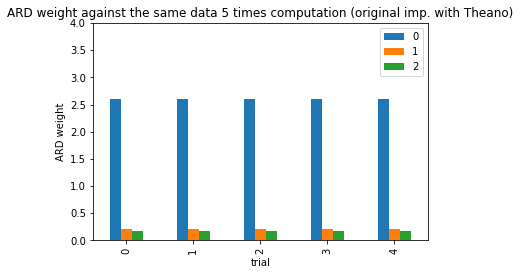

In [36]:
__df_theano_result = []
for i_trial, trial_result in enumerate(result_stacks):
    __df_theano_result.append(trial_result[0][0])
# end for
df_theano_result = pandas.DataFrame(__df_theano_result, index = list(range(0, n_trial)))
ax = df_theano_result.plot(kind='bar')
plt.title(f"ARD weight against the same data {n_trial} times computation (original imp. with Theano)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 4)

(0.0, 4.0)

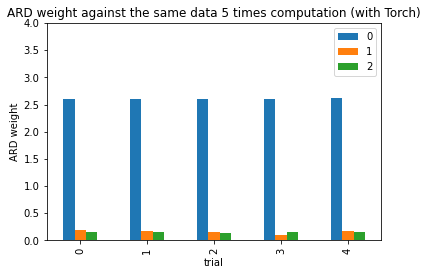

In [37]:
__df_torch_result = []
for i_trial, trial_result in enumerate(result_stacks):
    __df_torch_result.append(trial_result[0][1])
# end for
df_torch_result = pandas.DataFrame(__df_torch_result, index = list(range(0, n_trial)))
ax = df_torch_result.plot(kind='bar')
plt.title(f"ARD weight against the same data {n_trial} times computation (with Torch)")
plt.ylabel("ARD weight")
plt.xlabel("trial")
ax.set_ylim(0, 4)

### concolusion

With the above observation, we confirm that the ARD weight will __converage__ if we fix the input data and the sigma.

In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


# Study: with/without sigma optimizations

In [1]:
from model_criticism_mmd import ModelTrainerTheanoBackend, ModelTrainerTorchBackend

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
import numpy

In [3]:
size = 200
x = numpy.random.normal(loc=1.0, scale=0.0, size=(200, 3))
y = numpy.random.normal(loc=1.0, scale=50.0, size=(200, 3))

#x_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))
#y_2_and_3_dim = numpy.random.normal(loc=10.0, scale=0.2, size=(size, 2))

#x = numpy.concatenate([numpy.reshape(x_1st_dim, (size, 1)), x_2_and_3_dim], axis=1)
#y = numpy.concatenate([numpy.reshape(y_1st_dim, (size, 1)), y_2_and_3_dim], axis=1)

x_train = x[:100]
y_train = y[:100]
x_val = x[100:150]
y_val = y[100:150]
x_test = x[150:]
y_test = y[150:]

for n_dim in [0, 1, 2]:
    print(f'{n_dim+1} dim. mean(x)={x[:,n_dim].mean()} mean(y)={y[:,n_dim].mean()} var(x)={x[:,n_dim].var()} var(y)={y[:,n_dim].var()}')
# end for
assert len(x_train) == len(y_train) == 100
assert len(x_val) == len(y_val) == 50
assert len(x_test) == len(y_test) == 50

1 dim. mean(x)=1.0 mean(y)=-6.134923650595601 var(x)=0.0 var(y)=2483.728508442119
2 dim. mean(x)=1.0 mean(y)=2.7210920981855673 var(x)=0.0 var(y)=2754.3351727739832
3 dim. mean(x)=1.0 mean(y)=-0.9651828059532181 var(x)=0.0 var(y)=2459.4318239408385


In [8]:
n_epoch = 500
batch_size = 200
is_opt_sigma = False
# with sigma optimizations
trainer_theano = ModelTrainerTheanoBackend()
trained_obj_theano_without_sigma = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=False, init_log_sigma=0.0)

trainer_torch = ModelTrainerTorchBackend()
trained_obj_torch_without_sigma = trainer_torch.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=False, initial_log_sigma=0.0)

mmd2_theano, ratio_theano = trainer_theano.mmd_distance(x=x_test, y=y_test, sigma=trained_obj_theano_without_sigma.sigma)
mmd2_torch, ratio_torch = trainer_torch.mmd_distance(x=x_test, y=y_test)
print(f'MMD without the sigma optimization. Theano: {mmd2_theano} Torch: {mmd2_torch}')

Using sigma = 1.0
Compiling...
done
Input dim 3, representation dim 3
Training on 100 samples (batch 200), validation on 50 (batch 1000)
1 parameters to optimize: scales
     0: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
     5: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
    25: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
    50: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
   100: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
   200: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
   300: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
   400: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s
   500: avg tr

MMD without the sigma optimization. Theano: 1.02 Torch: 1.0199999999998544


In [9]:
n_epoch = 500
batch_size = 200
is_opt_sigma = True
# with sigma optimizations
trainer_theano = ModelTrainerTheanoBackend()
trained_obj_theano_with_sigma = trainer_theano.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=True)

trainer_torch = ModelTrainerTorchBackend()
trained_obj_torch_with_sigma = trainer_torch.train(x_train, y_train, num_epochs=n_epoch, batchsize=batch_size, opt_sigma=is_opt_sigma, x_val=x_val, y_val=y_val, init_sigma_median=True)

mmd2_theano_with_sigma, ratio_theano = trainer_theano.mmd_distance(x=x_val, y=y_val, sigma=trained_obj_theano_with_sigma.sigma)
mmd2_torch_with_sigma, ratio_torch = trainer_torch.mmd_distance(x=x_val, y=y_val)
print(f'MMD with the sigma optimization. Theano: {mmd2_theano_with_sigma} Torch: {mmd2_torch_with_sigma}')

Starting with sigma = median; optimizing it
Compiling...
done
Getting median initial sigma value...
61.6
Input dim 3, representation dim 3
Training on 100 samples (batch 200), validation on 50 (batch 1000)
2 parameters to optimize: scales, log_sigma
     0: avg train MMD^2  0.368900 obj -2.518141,  avg val MMD^2  0.329709  obj -2.069224  elapsed: 0s  sigma: 61.6
     5: avg train MMD^2  0.446184 obj -2.597464,  avg val MMD^2  0.425548  obj -2.172005  elapsed: 0s  sigma: 54.7
    25: avg train MMD^2  1.010300 obj -9.157834,  avg val MMD^2  1.019869  obj -7.540090  elapsed: 0s  sigma: 6.95
    50: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s  sigma: 1.3
   100: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s  sigma: 1.14
   200: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD^2  1.020000  obj -9.230143  elapsed: 0s  sigma: 1.14
   300: avg train MMD^2  1.010000 obj -9.220291,  avg val MMD

MMD with the sigma optimization. Theano: 1.02 Torch: 1.02


### Conclusion

Sigma optimization does not seem to give effects to compute MMD^2 distance.